In [ ]:
%rm -r segmentation_pytorch/
!git clone https://github.com/pablogiaccaglia/segmentation_pytorch
!pip install git+https://github.com/pablogiaccaglia/segmentation_pytorch
%cd /content/segmentation_pytorch/

Cloning into 'segmentation_pytorch'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 152 (delta 20), reused 24 (delta 10), pack-reused 113
Receiving objects: 100% (152/152), 146.41 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pablogiaccaglia/segmentation_pytorch to /tmp/pip-req-build-3nc3i69x
  Running command git clone -q https://github.com/pablogiaccaglia/segmentation_pytorch /tmp/pip-req-build-3nc3i69x
ERROR: File "setup.py" not found for legacy project git+https://github.com/pablogiaccaglia/segmentation_pytorch.
/content/segmentation_pytorch


In [ ]:
#@title **Google Drive connection**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import cv2
import time
import timeit
import random
import pathlib
import logging
import numpy as np
import albumentations
from tqdm import tqdm
from functools import partial
from typing import Tuple, List
import sys
!{sys.executable} -m pip install einops
!{sys.executable} -m pip install tensorflow_addons
!{sys.executable} -m pip install timm
!{sys.executable} -m pip install mmcv
!{sys.executable} -m pip install tensorboardX
!{sys.executable} -m pip install torchviz
!{sys.executable} -m pip install yacs
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from mmcv.runner import build_optimizer
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from torchviz import make_dot
from models.segformer import Segformer

#%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

from utils.label_utils import get_labels
from utils.lr_schedule import PolyLrUpdater
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval
from utils.data_utils import label_mapping, SegmentationDataset, display, cityscapes_label_to_rgb
from utils.train_utils import AverageMeter, CrossEntropy, BinaryCrossEntropy, get_confusion_matrix, create_logger
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d, scale_aug)

from configs.segformer_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImportError: ignored

In [ ]:
#@title **Data Loader**

def loadNumpyArrays(folderPath: str, arr, max, channels_first = False) -> np.ndarray:
    i = 0

    entries = os.listdir(folderPath)
    entries.sort()
    #print(entries)
    for entry in entries:

      if i==len(arr):
        break

      if ".DS_Store" not in str(entry) and "(1).npy" not in str(entry):

        l = np.load(folderPath + entry)
        #print(l.shape)
        
        if "IMG" in folderPath:
            l = np.dstack([l,l,l])
        else:
            l =l.squeeze()
            pass

        if "IMG" in folderPath:
          # l = tf.keras.applications.vgg16.preprocess_input(l)
          pass
        
        arr[i] = l
        i = i + 1
        if i==max:
          break

    if channels_first:
      try:
        arr = np.transpose(arr, (0, 3, 1, 2))
      except:
         pass
    
    return arr

def getDatasetArraysForNet() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    trainingImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Training-Final-IMG-Arrayss/"
    trainingMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Training-Final-MSK-Arrays/"
    validationImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Validation-Final-IMG-Arrays/"
    validationMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Validation-Final-MSK-Arrays/"
    testingImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Testing-Final-IMG-Arrays/"
    testingMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Testing-Final-MSK-Arrays/"

    h = w = 256
    batch1 = 3000
    batch2  = 5
    channels_first = True

    dim1 = (batch1, h, w, 3)
    dim2 = (batch1, h, w)
    dim3 = (batch2, h, w, 3)
    dim4 = (batch1, h, w)


    return loadNumpyArrays(folderPath = trainingImgDir, arr = np.ndarray(dim1, dtype = 'float32'), max = 3000, channels_first = channels_first), \
           loadNumpyArrays(folderPath = trainingMaskDir, arr = np.ndarray(dim2, dtype = 'uint8'), max = 3000, channels_first = channels_first), \
           loadNumpyArrays(folderPath = validationImgDir, arr = np.ndarray(dim1, dtype = 'float32'), max = 3000, channels_first = channels_first), \
           loadNumpyArrays( folderPath = validationMaskDir, arr = np.ndarray(dim2, dtype = 'uint8'), max = 3000, channels_first = channels_first), \
           loadNumpyArrays(folderPath = testingImgDir, arr = np.ndarray(dim3, dtype = 'float32'), max = 5), \
           loadNumpyArrays(folderPath = testingMaskDir, arr = np.ndarray(dim4, dtype = 'uint8'), max = 5, channels_first = channels_first)

In [ ]:
imgs_train, imgs_mask_train, imgs_val, imgs_mask_val, imgs_test, imgs_mask_test_gt = getDatasetArraysForNet()

def getTensorDataset(x, y):
  return TensorDataset(torch.Tensor(x), torch.Tensor(y))

train_dataloader = DataLoader(
    dataset = getTensorDataset(imgs_train, imgs_mask_train), 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True, # WHY DROPPING THE LAST BATCH IF NOT BATCH_SIZE COMPATIBLE?
    num_workers = 4, # HOW MANY SUB-PROCESSES USE FOR DATA LOADING
    prefetch_factor = 8, 
    pin_memory=True # the data loader will copy Tensors into device/CUDA pinned memory before returning them
    
)
valid_dataloader = DataLoader(
    dataset =getTensorDataset(imgs_val, imgs_mask_val), 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 8,
    pin_memory=True
    
)

x, y = next(iter(train_dataloader)) # first training sample
xv, yv = next(iter(valid_dataloader)) # first validation sample

x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


x.shape: (2, 3, 256, 256), x.type: torch.float32, [min(x), max(x)]: [18.000, 231.000]
y.shape: (2, 256, 256), y.type: torch.float32 
y unique: [0.0, 1.0]


In [ ]:
def mammograms_label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    print(mask.shape)
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for key, val in trainid2label.items():
        indices = mask == key
        mask_rgb[indices.squeeze()] = val.color 
    return mask_rgb


def display_blend(display_list):
    plt.figure(figsize=(10, 10), dpi=200)
    for i in range(len(display_list)):
        blend = cv2.addWeighted(display_list[i][0], 0.8, display_list[i][1], 0.6, 0)
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(blend)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
print(labels)

[Label(name='unlabeled', id=0, trainId=0, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)), Label(name='cancer', id=1, trainId=1, category='human', categoryId=6, hasInstances=True, ignoreInEval=False, color=(220, 20, 60))]


torch.Size([256, 256])
torch.Size([256, 256])


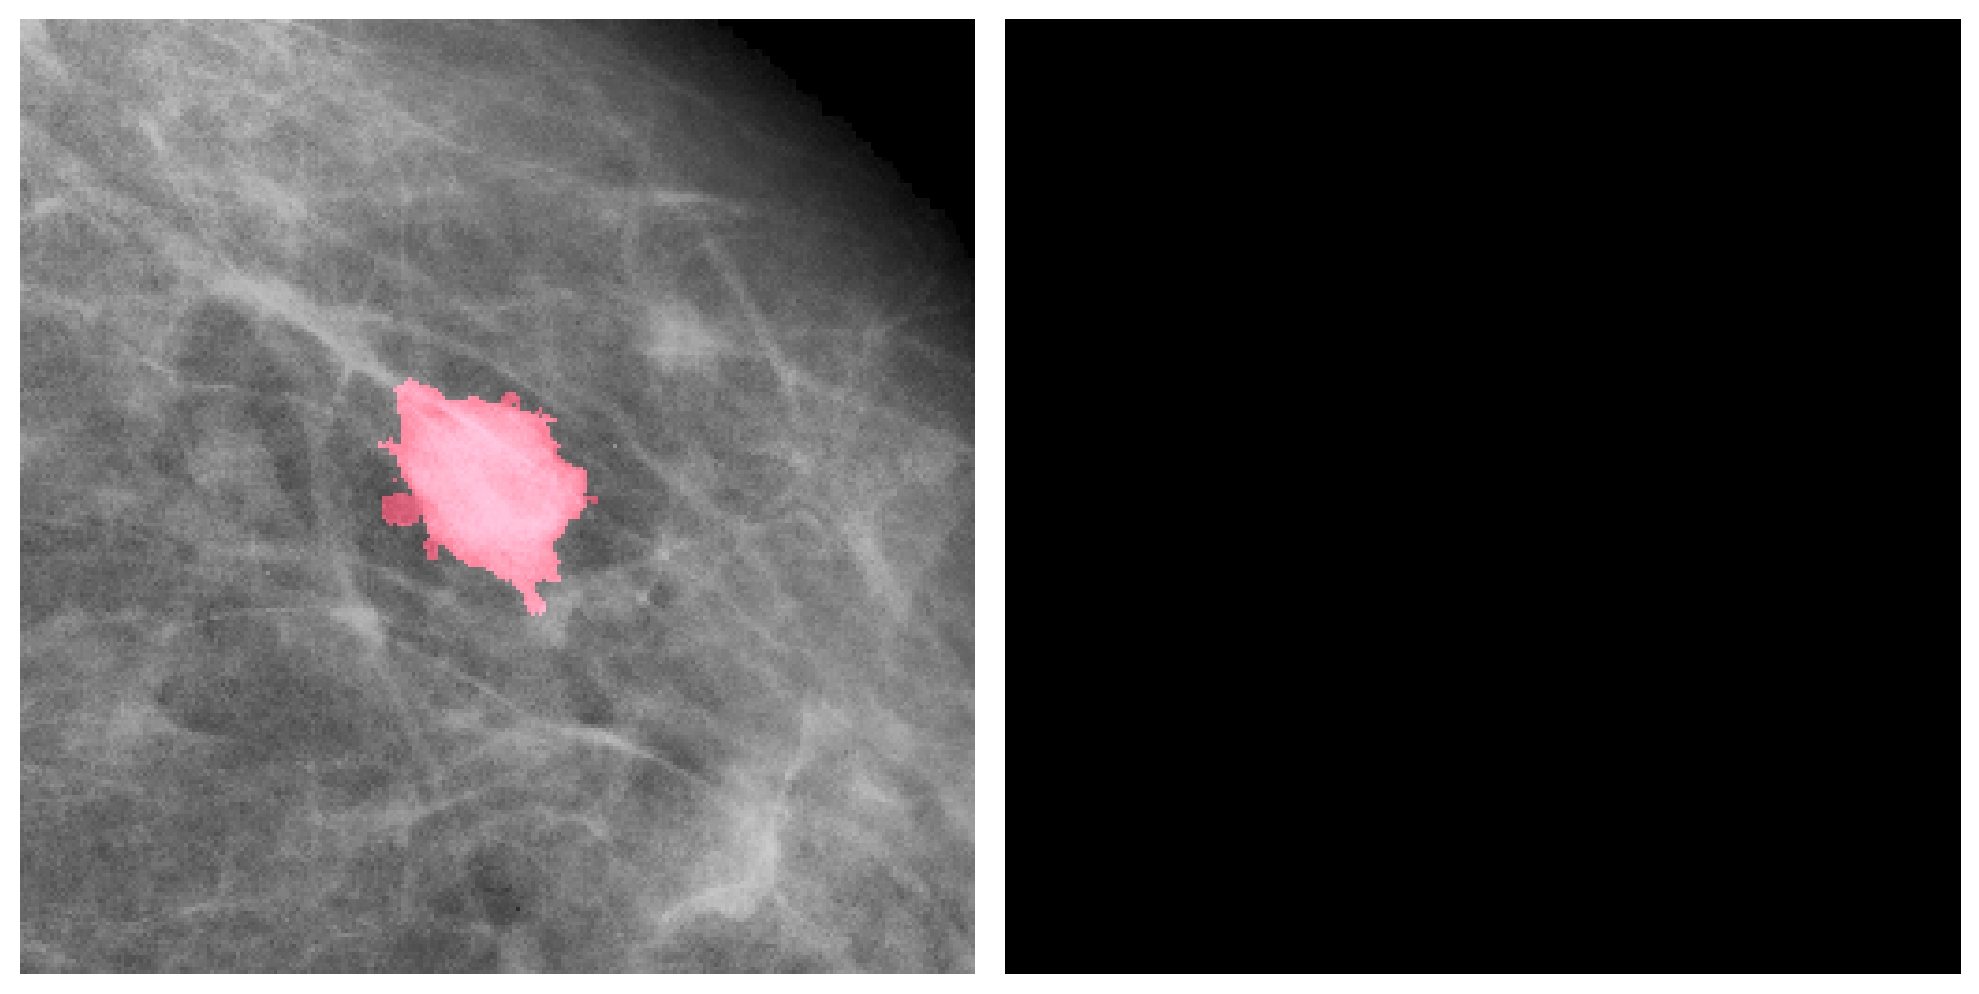

In [ ]:
idx = 1
display_blend([
    [re_normalize(x[idx].permute(1,2,0).numpy()), mammograms_label_to_rgb(y[idx])],
    [re_normalize(xv[idx].permute(1,2,0).numpy()), mammograms_label_to_rgb(yv[idx])]
])

In [ ]:
SEG_CFG = cfg.MODEL.B0

In [ ]:
model = Segformer(
    pretrained = None, # CHECK THIS TO LOAD PRETRAINED MODEL
    img_size = cfg.DATASET.CROP_SIZE[0], 
    patch_size = cfg.MODEL.PATCH_SIZE, 
    embed_dims = SEG_CFG.CHANNEL_DIMS, 
    num_heads = SEG_CFG.NUM_HEADS, 
    mlp_ratios = SEG_CFG.MLP_RATIOS,
    qkv_bias = SEG_CFG.QKV_BIAS, 
    depths = SEG_CFG.DEPTHS, 
    sr_ratios = SEG_CFG.SR_RATIOS,
    drop_rate = SEG_CFG.DROP_RATE, 
    drop_path_rate = SEG_CFG.DROP_PATH_RATE,
    decoder_dim = SEG_CFG.DECODER_DIM,
    norm_layer = partial(nn.LayerNorm, eps=1e-6), 
).to(device)

In [ ]:
#w = torch.FloatTensor([1,1])

# binary classification loss function
criterion = BinaryCrossEntropy(
).to(device)

# configuration for the model's optimizer
optimizer_cfg = dict(
    type=cfg.TRAIN.OPTIMIZER, #AdamW
    lr=cfg.TRAIN.BASE_LR,  #  0.00006
    weight_decay=cfg.TRAIN.WD, # 0.01
    paramwise_cfg=dict(
        custom_keys={
            'pos_block': dict(decay_mult=0.), 
            'norm': dict(decay_mult=0.),
            'head': dict(lr_mult=10.)
        }
))

# build model optimizer
optimizer = build_optimizer(model, optimizer_cfg)


# A LearningRateSchedule that uses a polynomial decay schedule
lr_scheduler = PolyLrUpdater(
    optimizer = optimizer,
    power = cfg.TRAIN.POWER,
    min_lr = cfg.TRAIN.MIN_LR,
    max_iters = cfg.TRAIN.DECAY_STEPS,
    epoch_len = len(train_dataloader),
    warmup = cfg.TRAIN.WARMUP,
    warmup_iters = cfg.TRAIN.WARMUP_ITERS,
    warmup_ratio = cfg.TRAIN.WARMUP_RATIO,
    by_epoch = cfg.TRAIN.BY_EPOCH,
)

In [ ]:
details = get_model_summary(model, x.cuda(), verbose=False)
print(details)


Total Parameters: 3,884,659
----------------------------------------------------------------------------------------------------
Total Multiply Adds (For Convolution and Linear Layers only): 25.74249267578125 GFLOPs
----------------------------------------------------------------------------------------------------
Number of Layers
Conv2d : 20 layers   LayerNorm : 30 layers   OverlapPatchEmbed : 4 layers   Linear : 44 layers   Dropout : 32 layers   Attention : 8 layers   Identity : 2 layers   DWConv : 8 layers   GELU : 8 layers   Mlp : 8 layers   Block : 8 layers   DropPath : 14 layers   LinearMLP : 4 layers   Dropout2d : 1 layers   


In [ ]:
def train(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    lr_scheduler, 
    scaler, 
    writer_dict,
    epoch, 
):
    model.train()
    
    ave_loss = AverageMeter() # object to compute and store the average and current value
    steps_tot = epoch*len(dataloader) # overall amount of steps, as the number of total passes of samples in the network (e.g epoch = 2, len(dataloander) = batch_size = 5, steps_tot = 10)
    writer = writer_dict['writer']
    global_steps = writer_dict['train_global_steps'] # global steps are the so far total number of epochs completed
    
    # loops over each batch (e.g: size 2 batch)
    for step, batch in enumerate(dataloader):
        X, y = batch # input, target
        X, y = X.cuda(), y.long().cuda()
        
        # Compute prediction and loss
        with torch.cuda.amp.autocast():
            pred = model(X.contiguous()) # Returns a contiguous in memory tensor containing the same data as self tensor
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False) # since the model's output is (64x64), it has to be rescaled to same size as input
            losses = loss_fn(pred, y) # computes loss for each sample
        loss = losses.mean() # single loss that is the averge of all the losses of the batch
        
        # Normalize loss to account for batch accumulation
        loss = loss / cfg.TRAIN.ACCUM_STEPS 
            
        # Backward pass to compute the gradients
        scaler.scale(loss).backward()
        
        # Weight update
        if ((step + 1) % cfg.TRAIN.ACCUM_STEPS == 0) or (step + 1 == len(dataloader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() # set the gradients to 0 after updating the weights, in this way the next accumulation of gradients starts from 0 gradient

            # update average loss <- WHY JUST THE FINAL LOSS IS CONSIDERED??????
            ave_loss.update(loss.item())

            # update learning schedule
            lr_scheduler.before_train_iter()
            lr = lr_scheduler.get_lr(int(steps_tot+step), cfg.TRAIN.BASE_LR)
        
        
    writer.add_scalar('train_loss', ave_loss.average(), global_steps) # current AVERAGE TRAINING LOSS
    writer_dict['train_global_steps'] = global_steps + 1 # UPDATES EPOCH STEP
    
    
def validate(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    writer_dict
):
    model.eval() 
    
    ave_loss = AverageMeter()  # object to compute and store the average and current value
    iter_steps = len(dataloader.dataset) // cfg.TRAIN.BATCH_SIZE # computes the number of steps required for a single pass of the whole dataset, given the batch size
    confusion_matrix = np.zeros((cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES, 1))
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            X, y = batch
            size = y.size()
            X, y = X.cuda(), y.long().cuda()
            
            pred = model(X.contiguous())
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False)
            losses = loss_fn(pred, y)
            loss = losses.mean()   
            
            if not isinstance(pred, (list, tuple)):
                pred = [pred]    
            for i, x in enumerate(pred):
                confusion_matrix[..., i] += get_confusion_matrix(
                    y, x, size, cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES)
            ave_loss.update(loss.item())
            
    pos = confusion_matrix[..., 0].sum(1)
    res = confusion_matrix[..., 0].sum(0)
    tp = np.diag(confusion_matrix[..., 0])
    IoU_array = (tp / np.maximum(1.0, pos + res - tp))
    mean_IoU = IoU_array.mean()
    
    writer = writer_dict['writer']
    global_steps = writer_dict['valid_global_steps']
    writer.add_scalar('valid_loss', ave_loss.average(), global_steps)
    writer.add_scalar('valid_mIoU', mean_IoU, global_steps)
    for key, val in trainid2label.items():
        if key != cfg.DATASET.IGNORE_LABEL and key != -1:
            if val.name == 'traffic light':
                val_name = "traffic_light"
            elif val.name == 'traffic sign':
                val_name = "traffic_sign"
            else:
                val_name = val.name
            writer.add_scalar('valid_mIoU_{}'.format(val_name), IoU_array[key], global_steps)    
    writer_dict['valid_global_steps'] = global_steps + 1
        
    return ave_loss.average(), mean_IoU, IoU_array

In [ ]:
def run_train_loop():
    
    logger, final_output_dir, tb_log_dir = create_logger(cfg, cfg_name=cfg.NAME, phase='train')
    
    writer_dict = {'writer': SummaryWriter(tb_log_dir), 'train_global_steps': 0, 'valid_global_steps': 0}

    best_mIoU = 0 # stores the best mean intersection over unit value
    
    start = timeit.default_timer()

    for epoch in range(cfg.TRAIN.EPOCHS):
        
        e_start = time.time()

        train(
            cfg=cfg, 
            dataloader=train_dataloader,
            model=model, 
            loss_fn=criterion, 
            optimizer=optimizer, 
            lr_scheduler=lr_scheduler,
            epoch=epoch, 
            scaler=torch.cuda.amp.GradScaler(),
            writer_dict=writer_dict
        )

        valid_loss, mean_IoU, IoU_array = validate(
            cfg=cfg, 
            dataloader=valid_dataloader, 
            model=model,  
            loss_fn=criterion,
            writer_dict=writer_dict
        )

        # logger.info('=> saving checkpoint to {}'.format(final_output_dir + 'checkpoint.pth.tar'))

        # saves the model after each epoch in a zipped format, overwritting the previous checkpoint
        torch.save({
            'epoch': epoch+1,
            'best_mIoU': best_mIoU,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(final_output_dir,'checkpoint.pth.tar'))

        if mean_IoU > best_mIoU:
            best_mIoU = mean_IoU
            torch.save(model.state_dict(), os.path.join(final_output_dir, 'best.pth')) # saves the best model so far
            
        e_end = time.time()
        t_epoch = e_end - e_start

        msg = 'Epoch {}/{} --- {:.1f}s, Loss: {:.3f}, MeanIoU: {: 4.4f}, Best_mIoU: {: 4.4f}'.format(
            epoch+1, cfg.TRAIN.EPOCHS, t_epoch, valid_loss, mean_IoU, best_mIoU)
        logging.info(msg)
        
    torch.save(model.state_dict(), os.path.join(final_output_dir, 'final_state.pth')) # saves the final model
    
    writer_dict['writer'].close()
    end = timeit.default_timer()
    logger.info('Hours: %d' % np.int((end-start)/3600))
    logger.info('Done')

In [ ]:
run_train_loop()

=> creating /content/segmentation_pytorch/outputs/cityscapes/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400
=> creating /content/segmentation_pytorch/logs/cityscapes/segformer/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400_2022-10-16-16-49


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 297, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

In [ ]:
mean_IoU, IoU_array, pixel_acc, mean_acc = testval(
    config, 
    eval_dataloader, 
    model, 
    sv_dir=cfg.OUTPUT_DIR, 
    sv_pred=True
)

In [ ]:
print("mnea IoU: {:.3f}, mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))

In [ ]:
for key, val in trainid2label.items():
    if key != cfg.DATASET.IGNORE_LABEL and key != -1:
        print("{} --- IoU: {:.2f}".format(val.name, IoU_array[key]))